## The Context

Finding the geometric relationship between two images is a common problem in computer vision. 

In our case, if we can find the relationship between the mini-map in one frame and the mini-map in another, we will understand how the player moves around the map.

One method that can be highly effective, if only a translation exists between two images, is to perform a 2D cross-correlation. This is rarely the case when we compare the mini-map between two frames because the play is free to rotate. However, I will adapt this technique in later posts to solve the rotation problem.

![](https://cgcooke.github.io/Blog//images/2020-12-22-The-Log-Polar-Transform-In-Practice/homographies.png)

When there is alignment between the two images, the correlation value will be maximum. While this is simple and effective, it has the potential to be computationally expensive, given the large number of operations required.

However, it's possible to solve this problem more efficiently using the Fast Fourier Transform (FFT).


## The Algorithm

In particular, we can take advantage of [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem). In particular, *The Fourier transform of a convolution of two signals is the pointwise product of their Fourier transforms*. In other words, convolution in the spatial domain is multiplication in the frequency domain.

Wikipedia has a great [page](https://en.wikipedia.org/wiki/Phase_correlation) that goes into more detail, but let's step through implementation in Python.

### Creating test data
First off, let's load in a bunch of libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import skimage.io
from skimage import filters
from skimage.color import rgb2gray
from skimage.filters import window, difference_of_gaussians

import scipy 

plt.rcParams['figure.figsize'] = [10, 10]

As a test, I will use an image from the popular video game *Call of Duty: Black Ops Cold War*. 

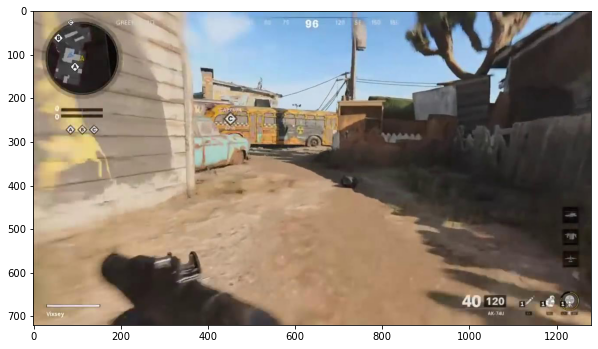

In [2]:
frame = skimage.io.imread('data/2020-12-19-FFT-Phase-Correlation/Frame.jpg')

plt.imshow(frame)
plt.show()

In particular, I will focus on the mini-map, which you can see in the top left of the image above.

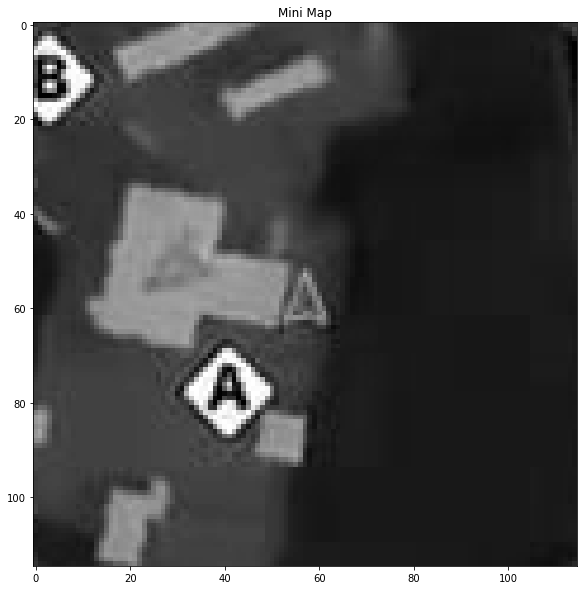

In [3]:
img1 = rgb2gray(frame[50:165,55:170,::-1])
plt.title('Mini Map')
plt.imshow(img1,cmap='gray')
plt.show()

Let's create some synthetic data. Using [scipy.ndimage.fourier_shift](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.fourier_shift.html), we can create a new image with a known shift.

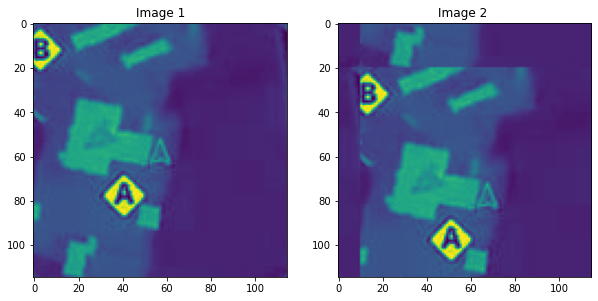

In [4]:
shift_x = 10
shift_y = 20

#Shift the img1 10 pixels to the right and 20 pixels down.
translated = np.roll(img1, shift_y, axis=0)
img2 = np.roll(translated, shift_x, axis=1)

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(img1)
ax[1].set_title("Image 2 ")
ax[1].imshow(img2)
plt.show()


### Finding the shift

Following the method described [here](https://en.wikipedia.org/wiki/Phase_correlation):

*Apply a window function (e.g., a Hamming window) on both images to reduce edge effects.*

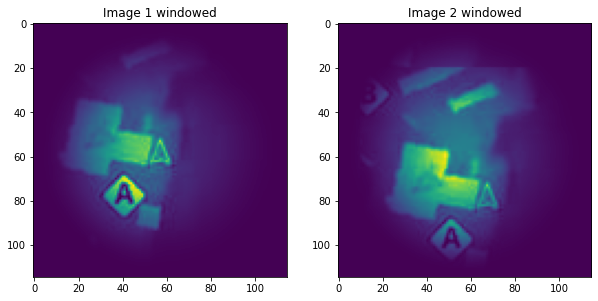

In [5]:
# window images
img1_wimage = img1 * window('hann', img1.shape)
img2_wimage = img2 * window('hann', img2.shape)

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1 windowed")
ax[0].imshow(img1_wimage)
ax[1].set_title("Image 2 windowed")
ax[1].imshow(img2_wimage)
plt.show()

*Calculate the discrete 2D Fourier transform of both images.*

In [6]:
# Compute the 2D FFT of each image
img1_fs = np.fft.fft2(img1_wimage)
img2_fs = np.fft.fft2(img2_wimage)

*Calculate the cross-power spectrum by taking the complex conjugate of the second result, multiplying the Fourier transforms together elementwise, and normalizing this product elementwise.*

In [7]:
#Compute the corss power spectrum
cross_power_spectrum = (img1_fs * img2_fs.conj()) / np.abs(img1_fs * img2_fs.conj())

*Obtain the normalized cross-correlation by applying the inverse Fourier transform.*

In [8]:
r = np.abs(np.fft.ifft2(cross_power_spectrum))

*Determine the location of the peak in r.*

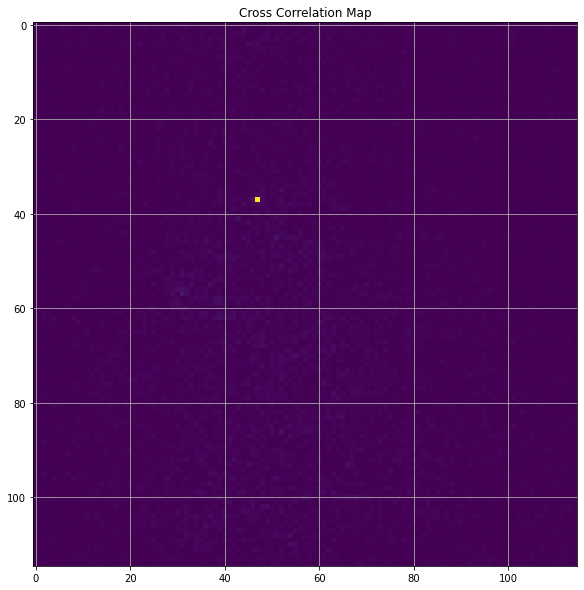

In [9]:
r = np.fft.fftshift(r)

plt.title('Cross Correlation Map')
plt.imshow(r)
plt.grid()
plt.show()

We can see the cross-correlation peak at (47, 37); usually, the peak would not be so well defined.

In [10]:
#Find the location of the peak
[py,px] = np.argwhere(r==r.max())[0]

cx,cy = 57,57
shift_x = cx - px
shift_y = cy - py

print(f'Shift measured X:{shift_x}, Y:{shift_y}')

Shift measured X:10, Y:20


Voilà!

We can now measure the shift between two images with only a 2D translation.

In a future post, I will look at what to do if there is a rotation and a translation.